# A first CausalNex tutorial

This tutorial will walk you through an example workflow using CausalNex to estimate whether a student will pass or fail an exam, by looking at various influences like school support, relationship between family members, and others. We will use the [Student Performance Data Set](https://archive.ics.uci.edu/ml/datasets/Student+Performance) published in the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml).


To work through this tutorial, you first need to create a new Python 3 notebook and download the [student.zip](https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip) file and extract `student-por.csv` from the zip file into the same directory, then copy and paste the code cells from this tutorial into your notebook.

## Structure Learning

Defining the structure of a Bayesian Network (BN) model can be done based on machine learning, domain knowledge, or a combination of both, where experts and algorithms contribute as equal partners.

Regardless of the approach, it is important to validate the structure by evaluating the BN - this will be covered later in the tutorial. In this section, we will focus on how to define a structure.

###  Structure from Domain Knowledge

We can manually define a structure model by specifying the relationships between different features.

First, we must create an empty structure model.

In [1]:
import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

Next, we can specify the relationships between features. For example, let's assume that experts tell us the following causal relationships are known (G1 is grade in semester 1):

* `health` -> `absences`
* `health` -> `G1`

We can add these relationships into our structure model:

In [2]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

### Visualising the Structure

We can examine a StructureModel by looking at the output of `sm.edges`

In [3]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

but it can often be more intuitive to visualise it. CausalNex provides a plotting module that allows us to do this.

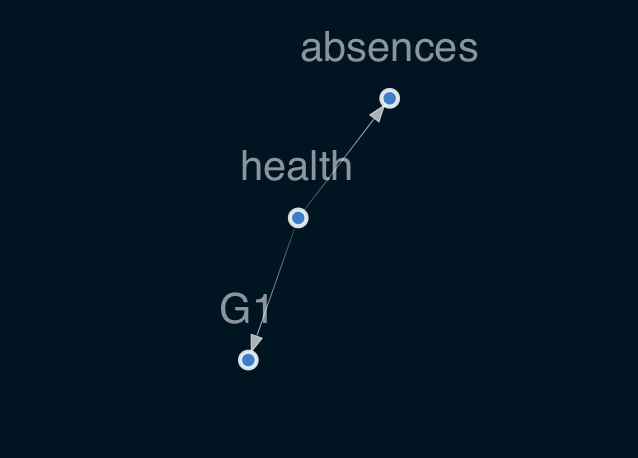

In [4]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

### Learning the Structure

As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the [NOTEARS](https://arxiv.org/abs/1803.01422) algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

### Preparing the Data for Structure Learning

In [5]:
import pandas as pd

data = pd.read_csv('student-por.csv', delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Looking at the data, we can see that features consist of numeric and non-numeric columns. We can drop sensitive features such as sex that we do not want to include in our model.

In [6]:
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


Next, we want to make our data numeric, since this is what the NOTEARS expects. We can do this by label encoding non-numeric variables.

In [7]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])
    
struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


We can now apply the NOTEARS algorithm to learn the structure.

In [9]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(struct_data)

and visualise the learned StructureModel using the plot function.

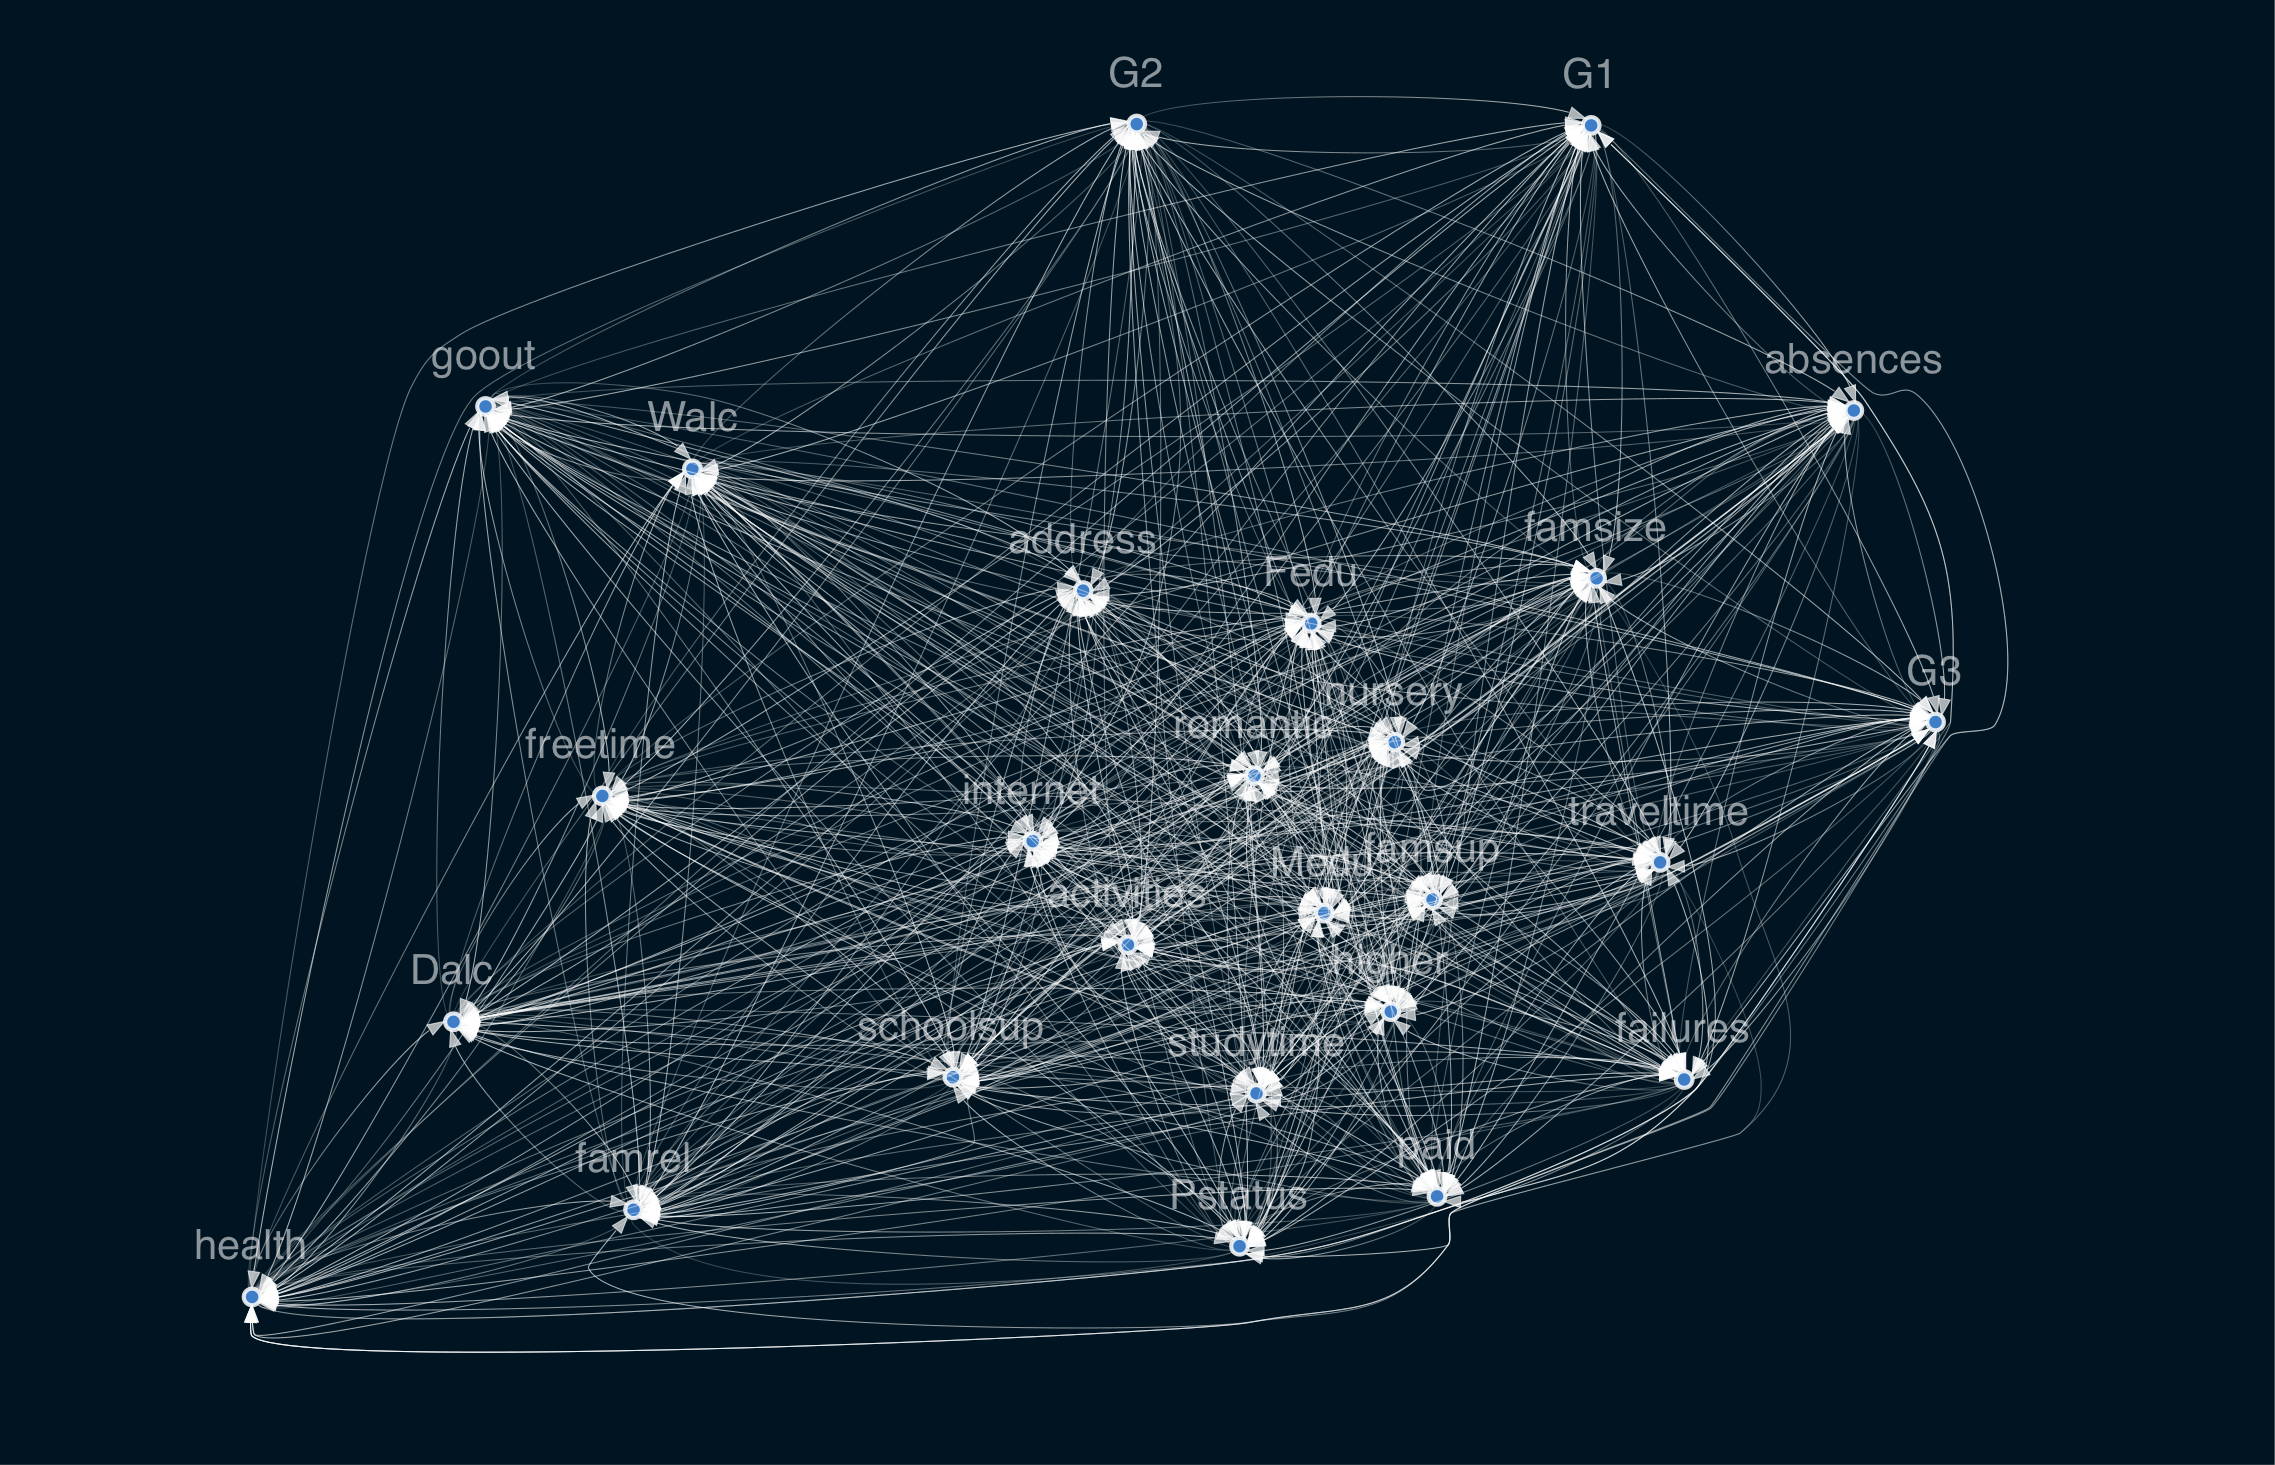

In [10]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

The reason why we have a fully connected graph here is we haven't applied thresholding to the weaker edges. Thresholding can be applied either by specifying the value for the parameter `w_threshold` in `from_pandas`, or we can remove the edges by calling the structure model function, `remove_edges_below_threshold`.

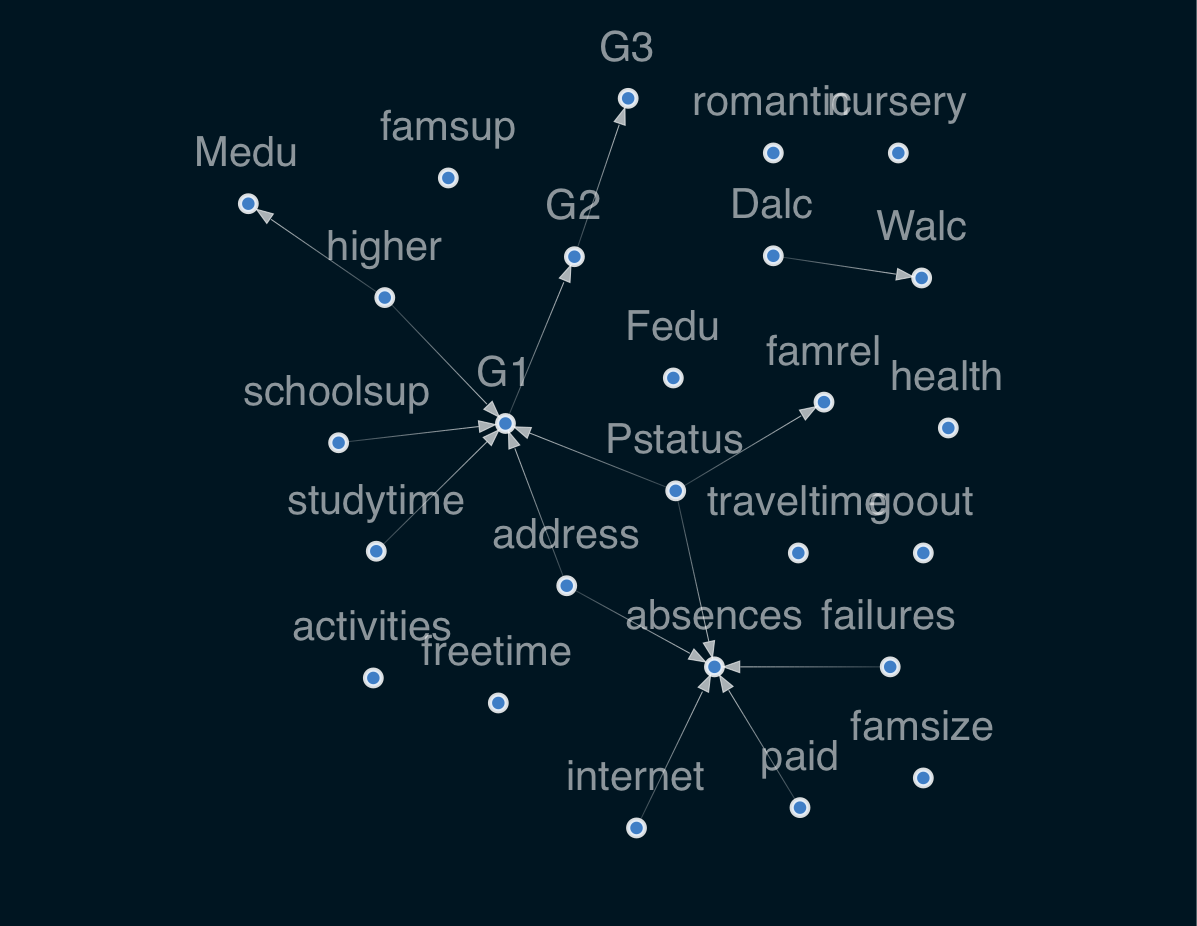

In [11]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In this structure, we can see that there are some relationships that appear intuitively correct:

* `Pstatus` affects `famrel` - if parents live apart, the quality of family relationship may be poor as a result. 
* `internet` affects `absences` - The presence of internet at home may cause student to skip class.
* `studytime` affects `G1` - longer studytime should have a positive impact on a student's result. 

However, there are some relationships that are certainly incorrect:

* `higher` affects `Medu` (Mother's education) - this relationship does not make sense as students who wants to pursue higher education does not affect mother's education. It could be the other way round.

To avoid these erroneous relationships, we can re-run structure learning with some added constraints:

In [12]:
sm = from_pandas(struct_data, tabu_edges=[("higher", "Medu")], w_threshold=0.8)

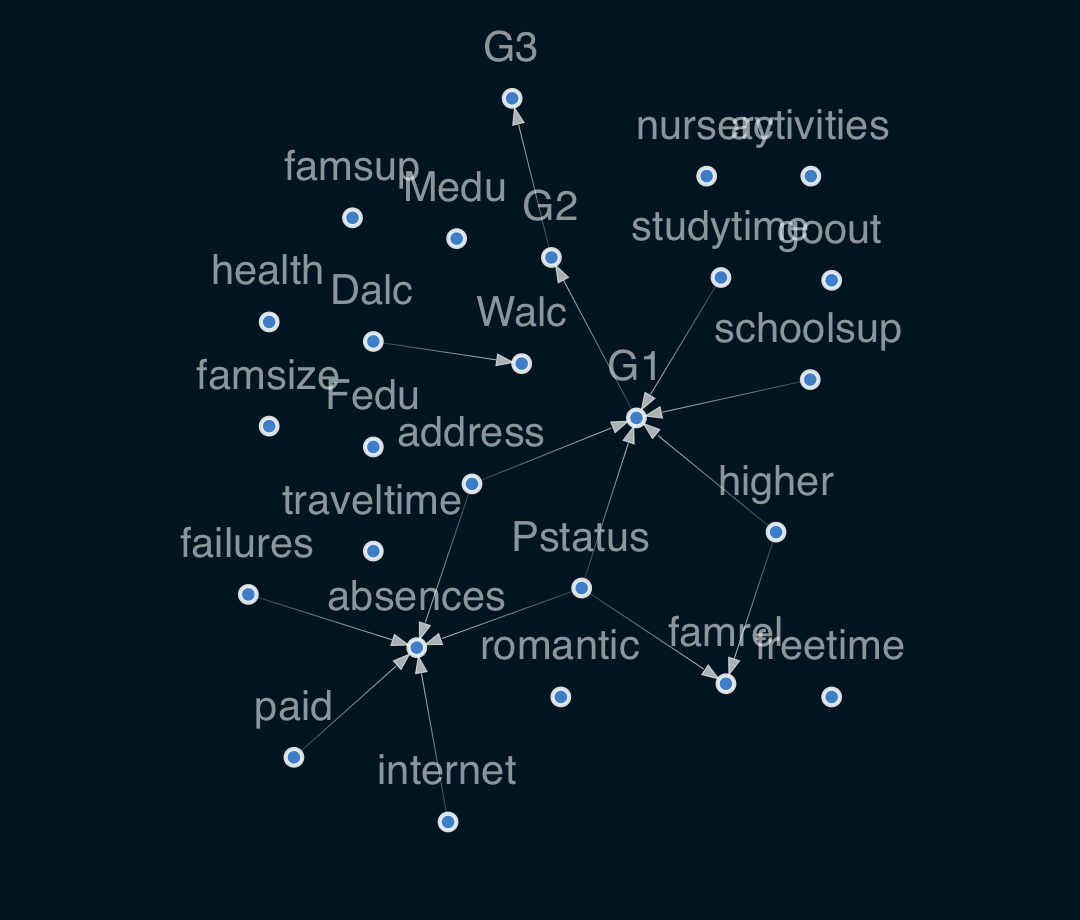

In [13]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

### Modifying the Structure

To correct erroneous relationships, we can incorporate domain knowledge into the model after structure learning. We can modify the structure model through adding and deleting the edges. For example, we can add and remove edges as:

In [14]:
sm.add_edge("failures", "G1")
sm.remove_edge("Pstatus", "G1")
sm.remove_edge("address", "G1")

We can now visualise our updated structure to confirm it looks reasonable.

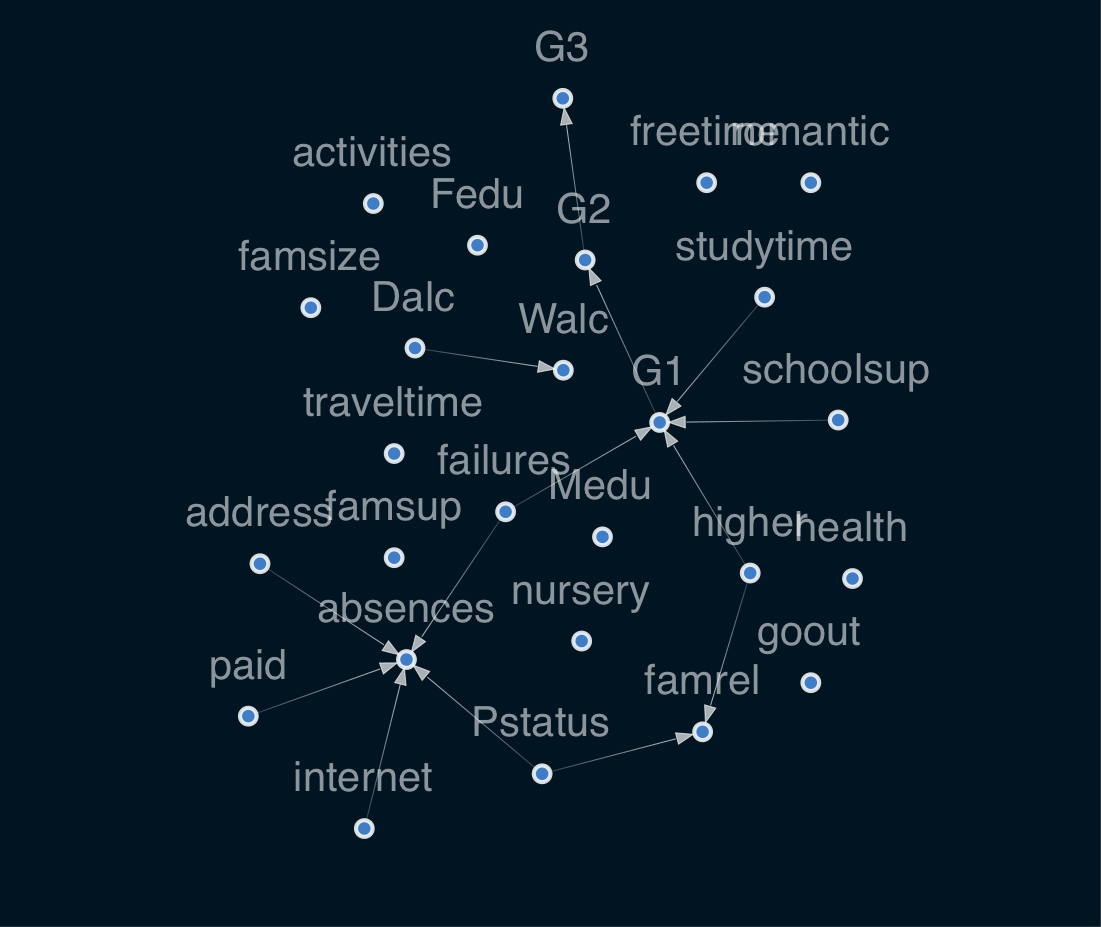

In [15]:
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

We can see there are two separate subgraphs here in the visualisation plot: `Dalc->Walc` and the other big subgraph. We can retrieve the largest subgraph easily by calling the StructureModel function `get_largest_subgraph()`.

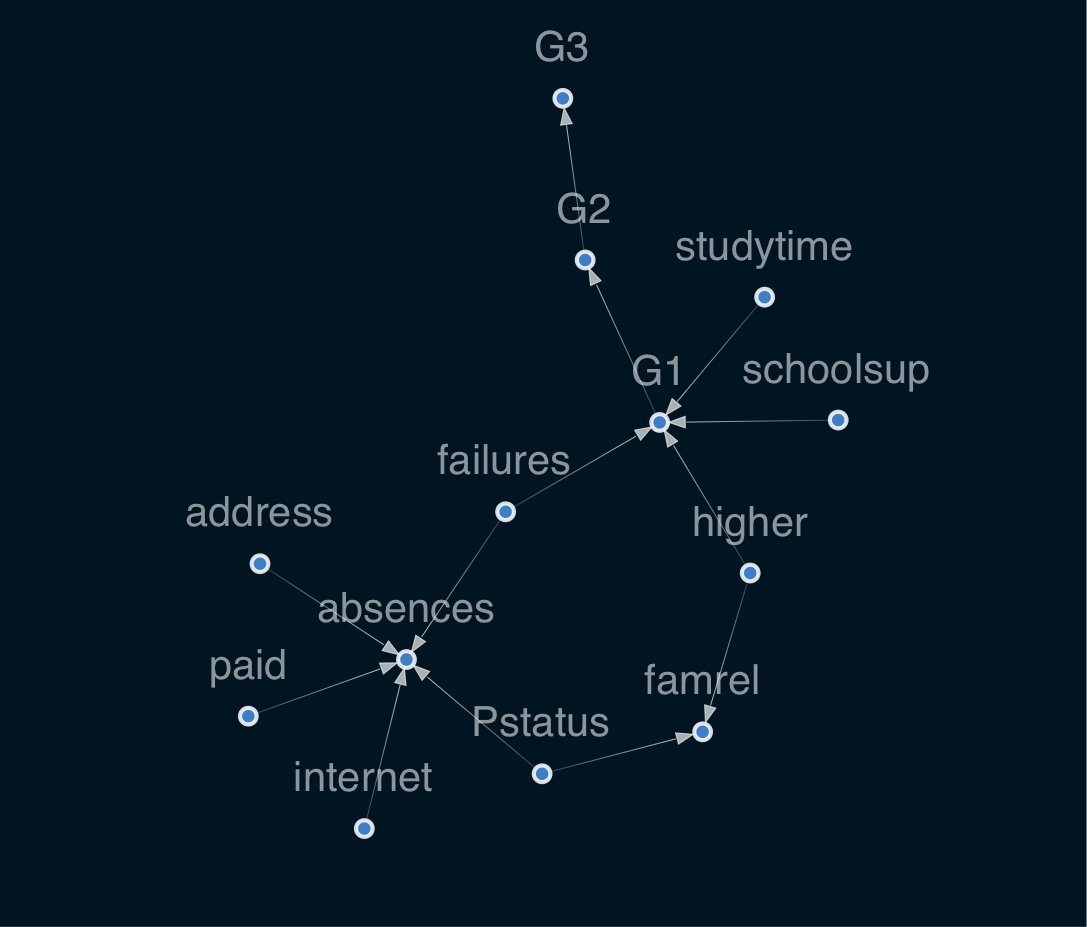

In [16]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm, 
    graph_attributes={"scale": "0.5"}, 
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

### Exporting the Structure

It is worth noting that `StructureModel` extends `networkx.DiGraph` (see [here](https://github.com/quantumblacklabs/causalnex/blob/develop/causalnex/structure/structuremodel.py)). We can therefore use `networkx`'s read/write methods to import/export our `StructureModel`. For example, we can export to a graphviz `.dot` file using `write_dot` function:

In [17]:
import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, 'graph.dot')

To export to other formats, please refer to `networkx`'s [documentation](https://networkx.org/documentation/stable/reference/readwrite/index.html).

## Fitting the Conditional Distribution of the Bayesian Network

After deciding on how the final structure model should look, we can instantiate a `BayesianNetwork`.

In [18]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

We are now ready to move on to learning the conditional probability distribution of different features in the `BayesianNetwork`.

### Preparing the Discretised Data

Bayesian Networks in CausalNex support only discrete distributions. Any continuous features, or features with a large number of categories, should be discretised prior to fitting the Bayesian Network. Models containing variables with many possible values will typically be badly fit, and exhibit poor performance.

For example, consider P(G2 | G1), where G1 and G2 have possible values 0 to 20. The discrete conditional probability distribution is therefore specified using 21x21 (441) possible combinations - most of which we will be unlikely to observe.

CausalNex provides a few helper methods to make discretisation easier. Let's start by reducing the number of categories in some of the categorical features by combining similar values. We will make numeric features categorical by discretisation, and then give the buckets meaningful labels.

### Cardinality of Categorical Features

To reduce the cardinality of categorical features we can define a map `{old_value: new_value}`, and use this to update the feature. For example, in the `studytime` feature, we make the studytime which is more than 2 (2 means 2 to 5 hours here, see https://archive.ics.uci.edu/ml/datasets/Student+Performance) into `long-studytime`, and the rest into `short-studytime`.

In [19]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
                else 'have-failure' for v in data_vals['failures']}
studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

Once we have defined our maps `{old_value: new_value}` we can update each feature, applying the mapping transformation.

In [20]:
discretised_data["failures"] = discretised_data["failures"].map(failures_map)
discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

### Discretising Numeric Features

To make numeric features categorical, they must first be discretised. CausalNex provides a helper class `causalnex.discretiser.Discretiser`, which supports several discretisation methods. For our data the `fixed` method will be applied, providing static values that define the bucket boundaries. For example, `absences` will be discretised into the buckets < 1, 1 to 9, and >=10. Each bucket will be labelled as an integer from zero.

In [21]:
from causalnex.discretiser import Discretiser

discretised_data["absences"] = Discretiser(method="fixed", 
                          numeric_split_points=[1, 10]).transform(discretised_data["absences"].values)
discretised_data["G1"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G1"].values)
discretised_data["G2"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G2"].values)
discretised_data["G3"] = Discretiser(method="fixed", 
                          numeric_split_points=[10]).transform(discretised_data["G3"].values)

### Create Labels for Numeric Features

To make the discretised categories more readable, we can map the category labels onto something more meaningful in the same way that we mapped category feature values.

In [22]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

### Train / Test Split

Like many other machine learning models, we will use a train and test split to help us validate our findings.

In [23]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

## Model Probability

With the learnt structure model from earlier and the discretised data, we can now fit the probability distrbution of the Bayesian Network. The first step in this is specifying all of the states that each node can take. This can be done either from data, or providing a dictionary of node values. We use the full dataset here to avoid cases where states in our test set do not exist in the training set. For real-world applications, these states may need to be provided using the dictionary method.

In [24]:
bn = bn.fit_node_states(discretised_data)

### Fit Conditional Probability Distributions

The `fit_cpds` method of `BayesianNetwork` accepts a dataset to learn the conditional probablilty distributions (CPDs) of each node, along with a method of how to do this fit.

In [25]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

Once we have the CPDs, we can inspect them through the `cpds` property, which is a dictionary of node->cpd.

In [26]:
bn.cpds["G1"]

failures    have-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75        0.806452            0.5            0.75   
Pass                0.25        0.193548            0.5            0.25   

failures                                                                 \
higher               yes                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612245            0.5            0.75   
Pass                 0.5        0.387755            0.5            0.25   

failures      no-failure                                                 \
higher                no                                                  
schoolsup             no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5        0.612903            0.5             0.5   
Pass                 0.5        0.387097            0.5             0.5   

failures                                                                 
higher               yes                                                 
schoolsup             no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail            0.032967         0.15016       0.111111        0.255814  
Pass            0.967033         0.84984       0.888889        0.744186

The CPD dictionaries are multi-indexed, and so the `loc` function can be a useful way to interact with them:

### Predict the State given the Input Data

The `predict` method of `BayesianNetwork` allows us to make predictions based on the data using the learnt Bayesian Network. For example, we want to predict if a student fails or passes their exam based on the input data. Imagine we have an incoming student data that looks like this:

In [27]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

Based on these data, we want to predict if this student fails their exam. Intuitively, we would expect this student to fail because they spend a shorter amount of time on their study and have failed in the past. Let's see how our Bayesian Network performs on this:

In [28]:
predictions = bn.predict(discretised_data, "G1")

In [29]:
print(f"The prediction is '{predictions.loc[18, 'G1_prediction']}'")

The prediction is 'Fail'


The prediction by the Bayesian Network turns out to be a `Fail`. Let's compare this to the ground truth:

In [30]:
print(f"The ground truth is '{discretised_data.loc[18, 'G1']}'")

The ground truth is 'Fail'


which turns out to be the same.

## Model Quality

To evaluate the quality of the model that has been learned, CausalNex supports two main approaches: Classification Report and Receiver Operating Characteristics (ROC) / Area Under the ROC Curve (AUC). In this section each will be discussed.

### Classification Report

To obtain a classification report using a BN, we need to provide a test set, and the node we are trying to classify. The report will predict the target node for all rows in the test set, and evaluate how well those predictions are made.

In [31]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "G1")

{'G1_Fail': {'precision': 0.7777777777777778,
  'recall': 0.5833333333333334,
  'f1-score': 0.6666666666666666,
  'support': 12},
 'G1_Pass': {'precision': 0.9107142857142857,
  'recall': 0.9622641509433962,
  'f1-score': 0.9357798165137615,
  'support': 53},
 'accuracy': 0.8923076923076924,
 'macro avg': {'precision': 0.8442460317460317,
  'recall': 0.7727987421383649,
  'f1-score': 0.8012232415902141,
  'support': 65},
 'weighted avg': {'precision': 0.8861721611721611,
  'recall': 0.8923076923076924,
  'f1-score': 0.8860973888496825,
  'support': 65}}

This report shows that the model we have defined is able to classify whether a student passes their exam reasonably well.

For the predictions where the student fails, the precision is good, but recall is bad. This implies that we can rely on predictions for this class when they are made, but we are likely to miss some of the predictions we should have made. Perhaps these missing predictions are as a result of something missing in our structure - this could be an interesting area to explore.

### ROC / AUC

Receiver Operating Characteristics (ROC), and the Area Under the ROC Curve (AUC) can be obtained using the `roc_auc` method within the CausalNex metrics module. Again, a test set and target node must be provided. The ROC curve is computed by micro-averaging predictions made across all states (classes) of the target node.

In [32]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "G1")
print(auc)

0.9181065088757396


The AUC value for our model is high, giving us confidence in the performance.

## Querying Marginals

After iterating over our model structure, CPDs, and validating our model quality, we can query our model under different observations to gain insights.

### Baseline Marginals

To query the model for baseline marginals that reflect the population as a whole, a `query` method can be used. First let's update our model using the complete dataset, since the one we currently have was only built from training data.

In [33]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

We can safely ignore these warnings, which let us know we are replacing the previously existing CPDs. 

For inference, we must create a new InferenceEngine from our BayesianNetwork, which lets us query the model. The query method will compute the marginal likelihood of all states for all nodes.

In [34]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["G1"] 

{'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}

The output observed tells us that `P(G1=Fail) = 0.25`, and the `P(G1=Pass) = 0.75`. As a quick sanity check, we can compute what proportion of our dataset are `Fail`, which should be approximately the same.

In [35]:
import numpy as np

labels, counts = np.unique(discretised_data["G1"], return_counts=True)
list(zip(labels, counts))

[('Fail', 157), ('Pass', 492)]

The proportion of the students who fail is `157 / (157+492) = 0.242` - which is close to our computed marginal likelihood.

### Marginals after Observations

We can also query the marginal likelihood of states in our network given some observations. These observations can be made anywhere in the network, and their impact will be propagated through to the node of interest.

Let's look at the difference in the likelihood of `G1` based on `studytime`.

In [36]:
marginals_short = ie.query({"studytime": "short-studytime"})
marginals_long = ie.query({"studytime": "long-studytime"})
print("Marginal G1 | Short Studtyime", marginals_short["G1"])
print("Marginal G1 | Long Studytime", marginals_long["G1"])

Marginal G1 | Short Studtyime {'Fail': 0.2776556433482524, 'Pass': 0.7223443566517477}
Marginal G1 | Long Studytime {'Fail': 0.15504850337837614, 'Pass': 0.8449514966216239}


Based on our data we can see that students who study longer are more likely to pass their exam.

## Do Calculus

CausalNex also supports simple Do-Calculus, allowing us to specify interventions. In this section we will take a look at the supported methods, and what they mean.

### Updating a Node Distribution

We can apply an intervention to any node in our data, updating its distribution using a `do` operator. This can be thought of as asking our model "What if" something were different. For example, we could ask what would happen if 100% of students wanted to go on to do higher education.

In [37]:
print("distribution before do", ie.query()["higher"])
ie.do_intervention("higher", 
                   {'yes': 1.0, 
                    'no': 0.0})
print("distribution after do", ie.query()["higher"])

distribution before do {'no': 0.10752688172043011, 'yes': 0.8924731182795698}
distribution after do {'no': 0.0, 'yes': 0.9999999999999998}


### Resetting a Node Distribution

We can reset any interventions that we make by using the `reset_intervention` method, and providing the node that we want to reset.

In [38]:
ie.reset_do("higher")

### Effect of Do on Marginals

We can again use `query` to examine the effect that an intervention has on our marginal likelihoods. In this case, we can look at how the likelihood of achieving a pass changes if 100% of students wanted to do higher education.

In [39]:
print("marginal G1", ie.query()["G1"])
ie.do_intervention("higher", 
                   {'yes': 1.0, 
                    'no': 0.0})
print("updated marginal G1", ie.query()["G1"])

marginal G1 {'Fail': 0.25260687281677224, 'Pass': 0.7473931271832277}
updated marginal G1 {'Fail': 0.20682952942551894, 'Pass': 0.7931704705744809}


In this case, we can see that if 100% of students wanted to do higher education (as opposed to 90% in our data population), then we estimate that pass rate would increase from 74.7% to 79.3%.